# Job Description Analysis

**Author**: Jerome Wynne (jeromewynne@das-ltd.co.uk)

**Created**: 5th November 2020  

**Environment**: wmchack

**Summary**: Classifying job roles: An NLP challenge using NHS Job descriptions, matching to Professional groups to (i.e. using FEDIP & AphA definition of analytical or civil service GORS/GSS/GDS).

---

### Write list of JSON files to Feather format 

In [1]:
import pandas as pd
from glob import glob
import json
from time import time
import html
import nltk
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from itertools import combinations_with_replacement

In [2]:
def load_job_descriptions():
    ''' Reads all .json files in /data into dataframe.

        The dataframe constructed can be viewed in /logs/info.log.

        Returns:
            pd.DataFrame: dataframe where each row corresponds to one 
                            file.
    '''
    fps = glob(r'..\data\*.json')
    fps = [fp for fp in fps if 'example' not in fp] # remove example.json
    list_of_page_dct = []
    for fp in fps: # read all of the files into a list of dicts
        with open(fp, 'r', encoding='utf-8') as f:
            list_of_page_dct += [json.load(f)]
    
    # flatten the list of dicts to a DataFrame
    df = pd.json_normalize(list_of_page_dct)

    return(df)

In [3]:
df = load_job_descriptions()
df.to_feather('../data/20201105_' + str(int(time())) + '_nhs_job_descriptions.feather')

---

## Load source data from Feather file, display essential information

In [4]:
fp = glob('../data/*.feather')[0]
df = pd.read_feather(fp)

In [5]:
# display head

df.head(3)

,@context,@type,datePosted,description,employmentType,industry,title,url,validThrough,baseSalary.@type,...,hiringOrganization.url,jobLocation.@type,jobLocation.address.@type,jobLocation.address.addressCountry,jobLocation.address.addressLocality,jobLocation.address.postalCode,jobLocation.geo.@type,jobLocation.geo.latitude,jobLocation.geo.longitude,hiringOrganization.logo
0,http://schema.org,JobPosting,2019-08-09T15:53:44+0100,&lt;p&gt;Stockton Hall is a highly specialist ...,FULL_TIME,Healthcare,Senior Staff Nurse £3000 Welcome Bonus,https://www.jobs.nhs.uk/xi/vacancy/915703981,2020-11-27T23:59:59+0000,MonetaryAmount,...,https://www.jobs.nhs.uk/xi/agency_info/?agency...,Place,PostalAddress,GB,"Stockton on the Forest, York",YO32 9UN,GeoCoordinates,53.9954,-1.00281,None
1,http://schema.org,JobPosting,2019-08-21T07:54:40+0100,&lt;p&gt;Birmingham Community Healthcare NHS F...,TEMPORARY,Healthcare,Bank Level 8a Advanced Clinical Practitioner,https://www.jobs.nhs.uk/xi/vacancy/915718669,2021-09-20T23:59:59+0100,MonetaryAmount,...,https://www.jobs.nhs.uk/xi/agency_info/?agency...,Place,PostalAddress,GB,Birmingham,B7 4BN,GeoCoordinates,52.4873,-1.88581,https://www.jobs.nhs.uk/xi/db_image/logo/12565...
2,http://schema.org,JobPosting,2019-08-21T13:41:57+0100,&lt;p&gt;&lt;strong&gt;Are you looking for a c...,TEMPORARY,Healthcare,Band 5 Bank Staff Nurse RN RGN,https://www.jobs.nhs.uk/xi/vacancy/915719754,2021-05-04T23:59:59+0100,MonetaryAmount,...,https://www.jobs.nhs.uk/xi/agency_info/?agency...,Place,PostalAddress,GB,Leicester/Leicestershire/Rutland,LE16 7BN,GeoCoordinates,52.4872,-.931093,None


In [6]:
# get fields, shape, and memory usage

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4706 entries, 0 to 4705
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   @context                             4706 non-null   object
 1   @type                                4706 non-null   object
 2   datePosted                           4706 non-null   object
 3   description                          4706 non-null   object
 4   employmentType                       4706 non-null   object
 5   industry                             4706 non-null   object
 6   title                                4706 non-null   object
 7   url                                  4706 non-null   object
 8   validThrough                         4706 non-null   object
 9   baseSalary.@type                     4706 non-null   object
 10  baseSalary.currency                  4706 non-null   object
 11  baseSalary.value.@type               4706 n

---

## Identify 'analyst' jobs for later reference

In [7]:
mask_analyst = df['title'].str.contains('Analyst').values

df[['title', 'url']][mask_analyst]

,title,url
255,Transformation and Integration Manager - Progr...,https://www.jobs.nhs.uk/xi/vacancy/916192104
964,Band 7 EPR Configuration Analyst,https://www.jobs.nhs.uk/xi/vacancy/916230379
1277,Epidemiology and Information Analyst,https://www.jobs.nhs.uk/xi/vacancy/916235893
1415,Business Analyst,https://www.jobs.nhs.uk/xi/vacancy/916236874
1574,Senior Information Analyst,https://www.jobs.nhs.uk/xi/vacancy/916238178
1726,Skids Data Analyst - Project Manager,https://www.jobs.nhs.uk/xi/vacancy/916239321
1923,Workforce Planning Support Analyst,https://www.jobs.nhs.uk/xi/vacancy/916240652
1945,Principal Analyst,https://www.jobs.nhs.uk/xi/vacancy/916240832
2080,Information Analyst,https://www.jobs.nhs.uk/xi/vacancy/916241821
2104,Analyst Programmer,https://www.jobs.nhs.uk/xi/vacancy/916241979


---

## Retain only description, view some examples

In [8]:
ser_desc = df['description'] 
ser_desc.index = df['url']

In [9]:
ser_desc[0]

'&lt;p&gt;Stockton Hall is a highly specialist hospital where patients requiring a medium secure care setting can maximise value from therapeutic interventions. Our services have produced excellent recovery results for patients and they are able to progress to low secure or locked rehabilitation if possible.&lt;/p&gt;\n&lt;p&gt;The facility is split across seven wards as follows:&lt;/p&gt;\n&lt;p&gt;16 bedded female ward - Mental Health and Personality Disorder&lt;br /&gt; 16 bedded male ward - Personality Disorder&lt;br /&gt; 8 bedded elderly male ward - for those with a settled in presentation in need of rehabilitation for mental illness and/or personality disorders&lt;br /&gt; Two 24 bedded male wards for mental health focus&lt;/p&gt;\n&lt;p&gt;The role:&lt;/p&gt;\n&lt;p&gt;Here at Stockton Hall Hospital in York, we have a vacancy for Staff Nurse – Grade 4.&lt;/p&gt;\n&lt;p&gt;Job Purpose:&lt;/p&gt;\n&lt;ul&gt;\n&lt;li&gt;To provide high profile leadership on a shift basis&lt;/li&gt

In [10]:
ser_desc[100]

'&lt;p&gt;Are you a Registered Nurse looking for flexibility, a good rate of pay and the opportunity to make a difference to people’s lives?&lt;/p&gt;\n&lt;p&gt;If you are an enthusiastic, caring and compassionate individual looking to work flexibly in a supportive environment then we’d love to hear from you!&lt;/p&gt;\n&lt;p&gt;&lt;strong&gt;EPUT are recruiting Nurses to work on our Trust bank across Essex covering a large geographical region.&lt;/strong&gt;&lt;/p&gt;\n&lt;p&gt;&lt;strong&gt;At EPUT, we put our people’s talents at the heart of improving lives – come and join us, together we can change lives. &lt;/strong&gt;&lt;/p&gt;\n&lt;p&gt;&lt;strong&gt;We are looking for Nurses who will embrace of values of being compassionate, empowering and open. If this sounds like you, apply now. &lt;/strong&gt;&lt;/p&gt;\n&lt;p&gt;Furthermore, we are seeking individuals that are able to work flexibly across a variety of shift patterns to suit your work life balance.&lt;/p&gt;\n&lt;p&gt;In re

In [11]:
ser_desc.iloc[100:101]

url
https://www.jobs.nhs.uk/xi/vacancy/916134096    &lt;p&gt;Are you a Registered Nurse looking fo...
Name: description, dtype: object

---

## Define normalization sequence

We can see that there are HTML entities scattered throughout the text.

Preprocessing pipeline:
1. Strip HTML entities and tags.
2. Strip newline characters.
3. Cast to lowercase.
4. Stem. 
5. Stop word removal. 

In [12]:
def preprocess(ser_desc: pd.Series):
    ser_desc = ser_desc.copy()
    ser_desc = ser_desc.apply(lambda value: html.unescape(value)) # replace entities
    ser_desc = ser_desc.str.replace(pat='<\/?[^>]*>', repl='') # strip html tags
    ser_desc = ser_desc.str.replace(pat='\\n', repl=' ') # strip newline chars
    ser_desc = ser_desc.str.lower()
    ser_desc = ser_desc.apply(lambda value: nltk.word_tokenize(value)) # splits string into list of tokens
    ser_desc = ser_desc.apply(lambda value: nltk.Text(value))
    #porter = nltk.PorterStemmer()
    #ser_desc = ser_desc.apply(lambda lst: [porter.stem(t) for t in lst]) 
    df_desc = ser_desc.to_frame()
    df_desc.columns = ['text']
    return df_desc

In [13]:
def get_keyword_presence(df_text: pd.DataFrame):
    ''' Creates a data frame containing counts of keywords.
    ''' 
    keywords = sorted(['analyst', 'analysis', 'analytical', 'data', 'prediction', 'predictive',
                       'sql', 'python', 'r', 'digital', 'software', 'automation', 'automate',
                       'maths', 'mathematics', 'physics', 'etl', 'informatics', 'bioinformatics',
                       'statistics', 'computing', 'computer science', 'excel', 'tableau', 'machine',
                       'programming', 'receptionist'])
    df_out = df_text.apply(axis=1, 
                           func=lambda rec: [float(rec['text'].count(kw) > 0) for kw in keywords],
                           result_type='expand')
    df_out.columns = keywords
    return df_out

In [14]:
# generate text, keyword presence data frames

df_text = ser_desc.pipe(preprocess) # field 'text' contains nltk Text objs
df_kw = get_keyword_presence(df_text)

In [34]:
"['" + "', '".join(list(df_text['text'][0])) + "']"

"['stockton', 'hall', 'is', 'a', 'highly', 'specialist', 'hospital', 'where', 'patients', 'requiring', 'a', 'medium', 'secure', 'care', 'setting', 'can', 'maximise', 'value', 'from', 'therapeutic', 'interventions', '.', 'our', 'services', 'have', 'produced', 'excellent', 'recovery', 'results', 'for', 'patients', 'and', 'they', 'are', 'able', 'to', 'progress', 'to', 'low', 'secure', 'or', 'locked', 'rehabilitation', 'if', 'possible', '.', 'the', 'facility', 'is', 'split', 'across', 'seven', 'wards', 'as', 'follows', ':', '16', 'bedded', 'female', 'ward', '-', 'mental', 'health', 'and', 'personality', 'disorder', '16', 'bedded', 'male', 'ward', '-', 'personality', 'disorder', '8', 'bedded', 'elderly', 'male', 'ward', '-', 'for', 'those', 'with', 'a', 'settled', 'in', 'presentation', 'in', 'need', 'of', 'rehabilitation', 'for', 'mental', 'illness', 'and/or', 'personality', 'disorders', 'two', '24', 'bedded', 'male', 'wards', 'for', 'mental', 'health', 'focus', 'the', 'role', ':', 'here', 

---

## Visualize vacancy description statistics

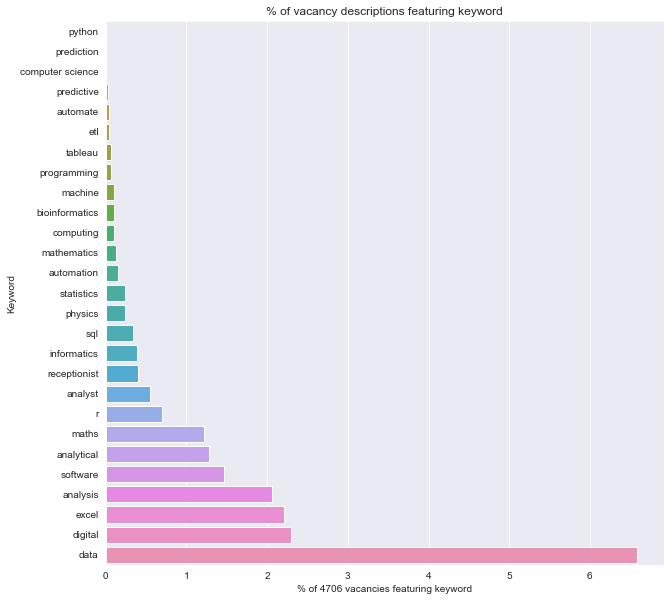

In [36]:
# plot bar chart of % of vacancy descriptions featuring keyword

def plot_keyword_pc(df: pd.DataFrame):
    ser_pc = df.mean(axis=0.)*100 # percentage of vacancies featuring keyword
    ser_pc = ser_pc.sort_values()
    f, ax = plt.subplots(figsize=(10, 10))
    sns.barplot(y=ser_pc.index, x=ser_pc.values, orient='h')
    ax.set(xlabel='% of {} vacancies featuring keyword'.format(df.shape[0]),
           ylabel='Keyword',
           title='% of vacancy descriptions featuring keyword')
    f.savefig('../data/img/001.png', dpi=1000)

plot_keyword_pc(df_kw)

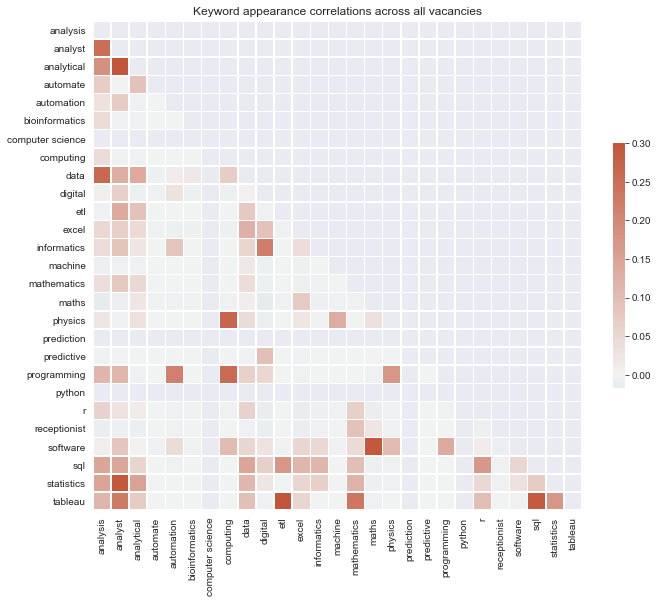

In [37]:
# plot heatmap of keyword correlations

def plot_corr_heatmap(df: pd.DataFrame):
    c = df.corr()
    mask = np.triu(np.ones_like(c, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(c, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    ax.set_title('Keyword appearance correlations across all vacancies')
    f.savefig('../data/img/002.png', dpi=1000)
    
plot_corr_heatmap(df_kw)

In [17]:
# measure similarity between descriptions using set diversity metrics

def jacard_index(text_1, text_2):
    return(len(set(text_1).intersection(set(text_2)))/len(set(text_1).union(set(text_2))))

def get_jacard_index_matrix(df_text: pd.DataFrame):
    df_jac = pd.DataFrame(np.nan, index=df_text.index, columns=df_text.index)
    n = df_text.shape[0]
    for i, j in combinations_with_replacement(range(n), 2):
        df_jac.iloc[i, j] = jacard_index(df_text.iloc[i, 0],
                                         df_text.iloc[j, 0])
    return(df_jac)

df_jac = get_jacard_index_matrix(df_text)

KeyboardInterrupt: 

In [ ]:
mask_analyst

In [20]:
df.iloc[0, 'description']

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types